# Testing

- Check DP bounds not exceeded (move a point and look for its detection probability)
- Check changing standard deviation/outputs of training data doesn't affect anything
- Check scaling lengthscale and input locations simultaneously doesn't affect anything

In [43]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import dp4gp

Y = np.array([0.0,1.0])
test_inputs = np.array([1.0,3.0])
X = np.array([0.0,2.0])
pseudo_inputs = np.array([0.0,2.0])
lengthscales = 10.0
sigma = 0.01
calc_normal=True
sens = 1.0
delta = 0.01
eps = 10.0

def get_peroutput_samples(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal,sens,delta,eps,Nsamples):
    test_inputs = np.hstack([test_inputs,X])
    test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)
    scalings = {}
    for i,o in zip(test_inputs,normal_peroutput_msense):
        scalings[i] = o
    new_test_cov, new_normal_msense, new_pseudo_msense, new_normal_peroutput_msense, new_pseudo_peroutput_msense, new_normal_mu, new_pseudo_mu, new_K_normal, new_K_pseudo, new_normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,scale=scalings,calc_normal=True)
    msense = np.max(new_normal_peroutput_msense) #new_normal_msense # 
    samps = []
    for it in range(Nsamples):
        samp = dp4gp.draw_sample(new_test_cov, test_inputs, new_normal_mu, msense, sens, delta, eps)
        samps.append(samp)
    return np.array(samps)

def get_normal_samples(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal,sens,delta,eps,Nsamples):
    test_inputs = np.hstack([test_inputs,X])
    test_cov, normal_msense, pseudo_msense, normal_peroutput_msense, pseudo_peroutput_msense, normal_mu, pseudo_mu, K_normal, K_pseudo, normal_covars = dp4gp.get_noise_scale(Y,test_inputs,X,pseudo_inputs,lengthscales,sigma,calc_normal=True)
    print normal_peroutput_msense
    print normal_msense
    print "NORMAL MU"
    print normal_mu
    msense = 8 #normal_msense #np.max(normal_peroutput_msense) #normal_msense
    #   the 8 comes from tot = np.dot(test_cov**-.5,np.max(np.dot(K_Nstar.T, invCov),1))
    #   np.sqrt(np.sum(tot**2))
    samps = []
    
    print "COVARIANCE USED:"
    covused = test_cov*(msense*sens*np.sqrt(2*np.log(2/delta))/eps)**2
    print covused
    for it in range(Nsamples):
        samp = dp4gp.draw_sample(test_cov, test_inputs, normal_mu, msense, sens, delta, eps)
        samps.append(samp)
    return np.array(samps), covused, normal_mu
 
fn = get_normal_samples #get_peroutput_samples # # 
ymean = 1.5
ystd = 1.0
Ytransformed = dp4gp.transform(Y.copy(),ymean,ystd)
sigmatransformed = sigma / ystd
Nsamples = 10000
samples, covused, mu = fn(Ytransformed,test_inputs,X,pseudo_inputs,lengthscales,sigmatransformed,calc_normal,sens,delta,eps,Nsamples)
samples = dp4gp.untransform(samples.copy(),ymean,ystd)

Y[1]+=1.0
Ytransformed = dp4gp.transform(Y.copy(),ymean,ystd)
sigmatransformed = sigma / ystd
samples_prime, covused, mu_prime = fn(Ytransformed,test_inputs,X,pseudo_inputs,lengthscales,sigmatransformed,calc_normal,sens,delta,eps,Nsamples)
samples_prime = dp4gp.untransform(samples_prime.copy(),ymean,ystd)

Calculating covariance between test inputs
Calculating covariance between training inputs and test inputs
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Maximum k* 1.00
Calculating K_NN
Calculating lambda
THING
(4, 2)
[[ 0.50245576  0.50245576]
 [-0.48760599  1.47281594]
 [ 0.99746236  0.00248715]
 [ 0.00248715  0.99746236]]
7.99532794434
[ 0.50245576  1.47281594  0.99746236  0.99746236]
25.376440343
NORMAL MU
[-1.00491152 -0.00499899 -1.49743711 -0.5024619 ]
COVARIANCE USED:
[[ 6.78184623  6.64755668  6.74802163  6.74802163]
 [ 6.64755668  6.78184623  6.48342792  6.74802163]
 [ 6.74802163  6.48342792  6.78184623  6.64755668]
 [ 6.74802163  6.74802163  6.64755668  6.78184623]]
Calculating covariance between test inputs
Calculating covariance between training inputs and test inputs
Calculating K_NM
Calculating K_MM
Calculating K_NN diagonals
Calculating K_star
Maximum k* 1.00
Calculating K_NN
Calculating lambda
THING
(4, 2)
[[ 0.50245576  0.50245576]
 [-

In [44]:
np.hstack([test_inputs,X])

array([ 1.,  3.,  0.,  2.])

In [45]:
#plt.plot(np.hstack([test_inputs,X]),samples.T,'.k',markersize=10,alpha=0.1);
#plt.plot(np.hstack([test_inputs,X])+0.2,samples_prime.T,'.b',markersize=10,alpha=0.1);

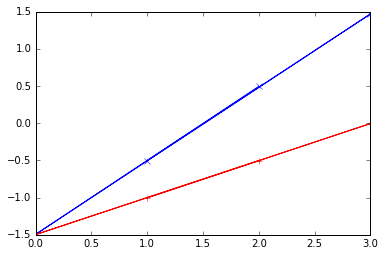

In [46]:
plt.plot(np.hstack([test_inputs,X]),mu_prime,'x-')
plt.plot(np.hstack([test_inputs,X]),mu,'r-+')

In [47]:
np.mean(samples,0) - np.mean(samples_prime,0)

array([-0.43089855, -1.40621886,  0.06864245, -0.9273975 ])

In the plot you can see that more noise has been added to the locations where the means differ more.

In [48]:
np.cov(samples.T)

array([[ 6.83202157,  6.69519646,  6.79699198,  6.79769817],
       [ 6.69519646,  6.82711388,  6.53015963,  6.79511421],
       [ 6.79699198,  6.53015963,  6.82934673,  6.69621955],
       [ 6.79769817,  6.79511421,  6.69621955,  6.8309415 ]])

Why does the sample mean not move in the direction the covariances would make us expect?!

I.e. As mean[2] has changed by -0.54, I'd expect mean[3] to move by about this too.

In [49]:
from scipy.stats import multivariate_normal
stepsize = 0.1
x, y = np.mgrid[-10:10:stepsize, -10:10:stepsize]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
for index in range(4):
    rv_sample = multivariate_normal(np.mean(samples,0)[index], np.cov(samples.T)[index,index])

    rv_sample_prime = multivariate_normal(np.mean(samples_prime,0)[index], np.cov(samples.T)[index,index]) #np.cov(samples_prime.T)[index,index])

    stepsize = 0.01
    histwidth = 1000
    p = rv_sample.pdf(np.arange(-histwidth,histwidth,stepsize))
    q = rv_sample_prime.pdf(np.arange(-histwidth,histwidth,stepsize))
    threshold = 0.003
    #threshold = 0.0027
    inc = (p>threshold) & (q>threshold)
    print "INDEX %d" % index
    print np.max(p[inc]/q[inc])
    print np.sum(p[inc])*stepsize**1
    print np.exp(eps)

INDEX 0
1.56580016069
0.993329821659
22026.4657948
INDEX 1
3.90877968755
0.985754494877
22026.4657948
INDEX 2
1.07601584514
0.994749321012
22026.4657948
INDEX 3
2.53655337159
0.990270281382
22026.4657948


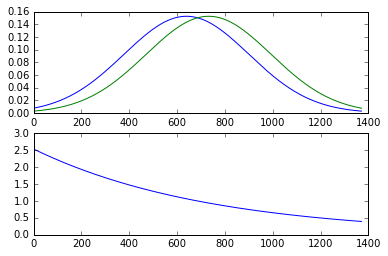

In [50]:
plt.subplot(2,1,1)
plt.plot(p[inc])
plt.plot(q[inc])
plt.subplot(2,1,2)
plt.plot((p[inc]/q[inc]))

Can we use logic such as:
 - we can have an arbitrary number of test points, so DP should be assured independently for each one.
 - but combining them might help, but we just test the one closest to the training point being adjusted.

## Multivariate

(-10.0, 10.0, -10.0, 10.0)

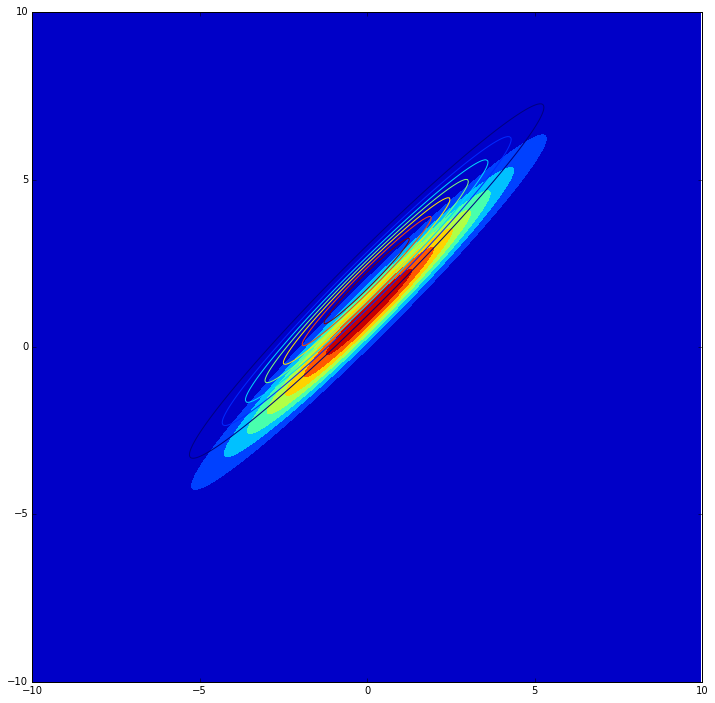

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,12])
from scipy.stats import multivariate_normal
stepsize = 0.05
histwidth = 10
x, y = np.mgrid[-histwidth:histwidth:stepsize, -histwidth:histwidth:stepsize]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
samp_cov = np.cov(samples.T)
samp_prime_cov = np.cov(samples_prime.T)
rv_sample = multivariate_normal(np.mean(samples,0)[2:4], covused[2:4,2:4])# samp_cov[2:4,2:4])
p = rv_sample.pdf(pos)
plt.contourf(x, y, p)
plt.axis('equal')
rv_sample_prime = multivariate_normal(np.mean(samples_prime,0)[2:4], covused[2:4,2:4])#samp_cov[2:4,2:4])
q = rv_sample_prime.pdf(pos)
plt.contour(x, y, q)
plt.axis('equal')

In [10]:
print samp_cov
print samp_prime_cov
#New
#array([[ 1223.61180407,  2743.23937924,  2021.51874817,  2019.47229901],
#       [ 2743.23937924,  6405.81067345,  4440.25416485,  4620.79860445],
#       [ 2021.51874817,  4440.25416485,  3374.22530665,  3302.33679849],
#       [ 2019.47229901,  4620.79860445,  3302.33679849,  3367.19571123]])

#Normal
#array([[ 3092.6585145 ,  3025.36943166,  3079.50103014,  3074.46465502],
#       [ 3025.36943166,  3084.45772257,  2951.02929042,  3070.32581593],
#       [ 3079.50103014,  2951.02929042,  3098.0204724 ,  3030.04319949],
#       [ 3074.46465502,  3070.32581593,  3030.04319949,  3088.06106818]])

[[ 168.48754869  165.08211406  167.70600031  167.60483331]
 [ 165.08211406  168.3290801   161.07500201  167.52527147]
 [ 167.70600031  161.07500201  168.59760997  165.1739652 ]
 [ 167.60483331  167.52527147  165.1739652   168.39733567]]
[[ 172.94954266  169.27333463  172.22034414  171.95560422]
 [ 169.27333463  172.35138337  165.2637803   171.65792311]
 [ 172.22034414  165.2637803   173.19626996  169.54794221]
 [ 171.95560422  171.65792311  169.54794221  172.66437279]]


In [11]:
threshold = 0.000028
#threshold = 0.0027
inc = (p>threshold) & (q>threshold)
print np.max(p[inc]/q[inc])
print np.sum(p[inc])*(stepsize**2)
print np.sum(p)*(stepsize**2)
print np.exp(eps)

3.10761475855
0.990295144354
1.0
7.38905609893


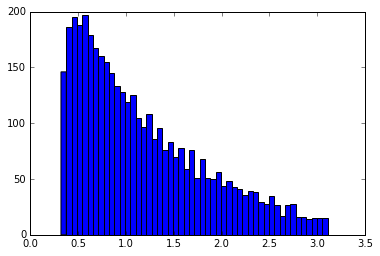

In [12]:
plt.hist(p[inc]/q[inc],50);

# Idea for future DP reduction...

If we know inputs lie at least $d$ apart, then in calculation of $K^{-1}$ infinity norm:

1. Find largest value in column, scale by $k(0)$
2. Find next largest value, scale by $k(\frac{d}{2})$
3. Find next largest ... scale by $k(\frac{2d}{2})$
4. Find next largest ... scale by $k(\frac{3d}{2})$
5. Find next largest ... scale by $k(\frac{4d}{2})$
6. ...

In [ ]:
dp4gp.k(0,2,lengthscales,None,dp4gp.rbf)

Also just remove from the test set all those columns that are causing problems!...no: the normal bound doesn't use the test locations.

# Other...

In [ ]:
np.array([])